In [1]:
import testing_2 as tst
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calplot 
import datetime 
from pickle import dump,load

In [2]:
def importa2(archivo):
 nombres=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion']
 esoru=pd.read_csv(archivo,names=nombres,skiprows=1)
 esoru.tiempo=pd.to_datetime(esoru.tiempo,format='%Y-%m-%d %H:%M:%S')
 esoru.set_index('tiempo',inplace=True)
 return(esoru)

def importa(archivo):
 nombres=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Viento','Presion','WDir_Avg','Rain_Tot']
 esoru=pd.read_csv(archivo,names=nombres,skiprows=1)
 esoru.tiempo=pd.to_datetime(esoru.tiempo,format='%Y-%m-%d %H:%M:%S')
 esoru.set_index('tiempo',inplace=True)
 return(esoru)

def SsTMX(N,tiest):
    #(día juliano, tiempo estándar)
    lat=18.8397315*np.pi/180
    logloc=99.2364961
    logest=90
    #N=int(N)
    delta=23.45*np.pi/180*np.sin(((2*np.pi)/365)*(284+N))
    B=(N-1)*((2*np.pi)/365) 
    Et=229.2*(.000075+(.001868*np.cos(B))-(.032077*np.sin(B))-(.014615*np.cos(2*B))-(.04089*np.sin(2*B)))
    #cenit=[]
    tsol=tiest+(4*(logest-logloc))+Et
    omega=.25*(tsol-720)
    theta=np.rad2deg(np.arccos((np.cos(lat)*np.cos(np.radians(omega))*np.cos(delta))+(np.sin(delta)*np.sin(lat))))
    Ss=(np.sin(np.radians(omega))*np.cos(delta))/np.sin(np.radians(theta))
    #altura=90-theta
    return(Ss)

def CsTMX(N,tiest):
    #(día juliano, tiempo estándar)
    lat=18.8397315*np.pi/180
    logloc=99.2364961
    logest=90
    #N=int(N)
    delta=23.45*np.pi/180*np.sin(((2*np.pi)/365)*(284+N))
    B=(N-1)*((2*np.pi)/365) 
    Et=229.2*(.000075+(.001868*np.cos(B))-(.032077*np.sin(B))-(.014615*np.cos(2*B))-(.04089*np.sin(2*B)))
    #cenit=[]
    tsol=tiest+(4*(logest-logloc))+Et
    omega=.25*(tsol-720)
    theta=np.rad2deg(np.arccos((np.cos(lat)*np.cos(np.radians(omega))*np.cos(delta))+(np.sin(delta)*np.sin(lat))))
    Cs=((np.sin(lat)*np.cos(np.radians(omega))*np.cos(delta))-(np.cos(np.radians(theta))*np.sin(delta)))/np.sin(np.radians(theta))
    #altura=90-theta
    return(Cs)

def gammaprimaTMX(N,tiest):
    #(día juliano, tiempo estándar)
    lat=18.8397315*np.pi/180
    logloc=99.2364961
    logest=90
    #N=int(N)
    delta=23.45*np.pi/180*np.sin(((2*np.pi)/365)*(284+N))
    B=(N-1)*((2*np.pi)/365) 
    Et=229.2*(.000075+(.001868*np.cos(B))-(.032077*np.sin(B))-(.014615*np.cos(2*B))-(.04089*np.sin(2*B)))
    #cenit=[]
    tsol=tiest+(4*(logest-logloc))+Et
    omega=.25*(tsol-720)
    theta=np.rad2deg(np.arccos((np.cos(lat)*np.cos(np.radians(omega))*np.cos(delta))+(np.sin(delta)*np.sin(lat))))
    gammaprima=np.rad2deg(np.arctan((np.sin(np.radians(omega))*np.cos(delta))/((np.sin(lat)*np.cos(np.radians(omega))*np.cos(delta))-(np.cos(np.radians(theta))*np.sin(delta)))))
    #altura=90-theta
    return(gammaprima)

def azimuthTMX(N,tiest):
    if (CsTMX(N,tiest)>=0).bool:
        azimuth=gammaprimaTMX(N,tiest)
    if (CsTMX(N,tiest)<0 & SsTMX(N,tiest)<0).bool:
        azimuth=-180+gammaprimaTMX(N,tiest)
    if (CsTMX(N,tiest)<0 & SsTMX(N,tiest)>0).bool:
        azimuth=180+gammaprimaTMX(N,tiest)
    return (azimuth)

def alturaTMX(N,tiest):
    #(día juliano, tiempo estándar)
    lat=18.8397315*np.pi/180
    logloc=99.2364961
    logest=90
    #N=int(N)
    delta=23.45*np.pi/180*np.sin(((2*np.pi)/365)*(284+N))
    B=(N-1)*((2*np.pi)/365) 
    Et=229.2*(.000075+(.001868*np.cos(B))-(.032077*np.sin(B))-(.014615*np.cos(2*B))-(.04089*np.sin(2*B)))
    cenit=[]
    tsol=tiest+(4*(logest-logloc))+Et
    omega=.25*(tsol-720)
    theta=np.rad2deg(np.arccos((np.cos(lat)*np.cos(np.radians(omega))*np.cos(delta))+(np.sin(delta)*np.sin(lat))))
    altura=90-theta
    return(altura)

def nightzero_timeprep(df,path_archivo,archivo_nombre,save=True,nightzero=True): #Corrige datos y agrega variables temporales (azimuth y altura solar)
    df['diajuliano']=df.index.dayofyear
    df['minutodia']=(df.index.hour*60)+df.index.minute
    df['alturasolar']=alturaTMX(df.diajuliano,df.minutodia)
    #df['azimuth']=azimuthTMX(df.diajuliano,df.minutodia)
    df['Cs']=CsTMX(df.diajuliano,df.minutodia)
    df['Ss']=SsTMX(df.diajuliano,df.minutodia)
    df['azimuth']=gammaprimaTMX(df.diajuliano,df.minutodia)
#df.loc[df.Cs>=0,'azimuth']=gammaprimaTMX(df.diajuliano,df.minutodia)
#df['azimuth']=df.loc[(df.Cs<0) & (df.Ss>0),'azimuth']+180
    df.loc[(df.Cs<0) & (df.Ss<0),'azimuth']=df.loc[(df.Cs<0) & (df.Ss<0),'azimuth']-180#=-180#gammaprimaTMX(df.diajuliano,df.minutodia)
    df.loc[(df.Cs<0) & (df.Ss>0),'azimuth']=df.loc[(df.Cs<0) & (df.Ss>0),'azimuth']+180
    #df['declinacion']=declinacionTMX(df.diajuliano)
    if nightzero==True:
        df.loc[df.alturasolar<0,'prediccion']=0
        df.loc[df.alturasolar<0,'Ig']=0
        df.loc[df.alturasolar<0,'Ib']=0
    dfcorr_noche=df[['Ig','Ib','To','RH','WS','WD','P','alturasolar','azimuth']]
    if save==True:
        dfcorr_noche.to_csv(path_archivo+archivo_nombre)
    return(dfcorr_noche)

# Importo datos incompletos

In [3]:
tmx_preANN=pd.read_csv('../01_data/Temixco_2018_incompleto.csv',index_col=0,parse_dates=True)
tmx_preANN

,Ib,Ig,To,RH,WS,WD,P,Eg
time,,,,,,,,
2018-01-01 00:00:00,0.000,0.0,18.70,36.34,1.422,316.0,87864.11,0.0
2018-01-01 00:10:00,0.002,0.0,18.95,35.29,1.008,283.7,87876.37,0.0
2018-01-01 00:20:00,0.170,0.0,18.94,35.43,1.565,326.0,87888.64,0.0
2018-01-01 00:30:00,0.371,0.0,18.77,35.89,2.175,354.5,87887.21,0.0
2018-01-01 00:40:00,0.305,0.0,18.81,36.34,1.902,348.0,87886.91,0.0
...,...,...,...,...,...,...,...,...
2018-12-31 23:10:00,0.125,0.0,18.51,47.29,1.715,332.2,87484.32,0.0
2018-12-31 23:20:00,0.000,0.0,18.26,48.02,1.703,320.5,87470.70,0.0
2018-12-31 23:30:00,0.044,0.0,18.39,46.84,2.887,335.7,87455.03,0.0


# Agrego columnas de angulos solares

### Y salvo el archivo para ocuparlo despues

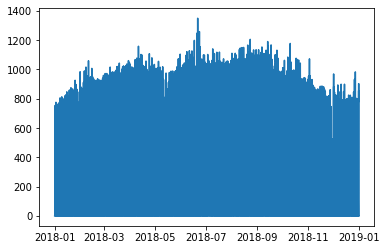

In [4]:
path_archivo='../01_data/02_toimpute/'
nombre_archivo='tmxincompleto_2018_angsolares.csv'
tmx_nocheang=nightzero_timeprep(tmx_preANN,path_archivo,nombre_archivo,nightzero=True)
# tmx_nocheang=nightzero_timeprep(tmx_preANN,path_archivo,nombre_archivo,nightzero=False)
plt.plot(tmx_nocheang.Ig)

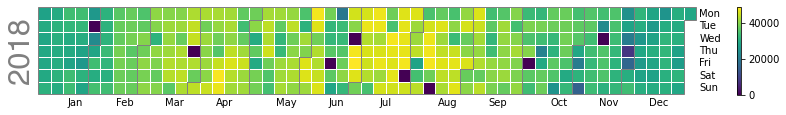

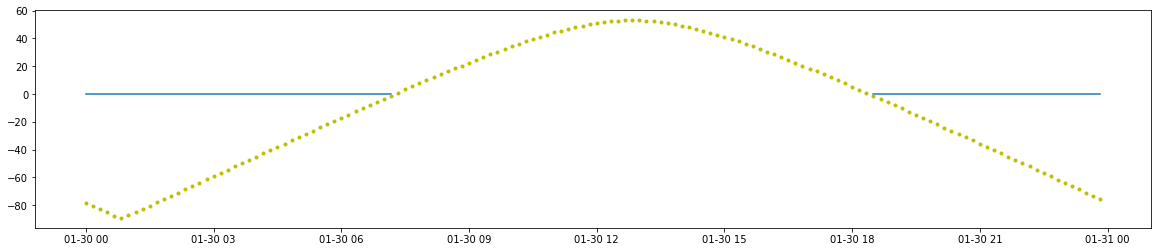

In [5]:
calplot.calplot(tmx_nocheang.Ig)
fig, ax=plt.subplots(figsize=(20,4))
ax.plot(tmx_nocheang.Ig['2018-01-30'])
ax.plot(tmx_nocheang.alturasolar['2018-01-30'],'y.')

## Importo archivo con angulos solares agregados

In [6]:
tmx_inc=pd.read_csv(path_archivo+nombre_archivo,parse_dates=True)

# Identifico d'onde se encuentran los vac'ios de datos (fecha y no. de dato)

In [7]:
nantmx=tmx_inc[tmx_inc.Ig.isnull()]
ind=list(nantmx.index)
isteps=[]
datavoid=1
datavoids=[]
print(nantmx.time[ind[0]])
print('at index',ind[0])
isteps.append(ind[0])
for x in range(0,len(ind)-1,1):
    if ind[x+1]-ind[x]>1:
        print(datavoid)
        datavoids.append(datavoid)
        datavoid=1
        print('new_void_at:',nantmx.time[ind[x+1]])
        isteps.append(ind[x+1])
        print('at index',ind[x+1])
    else:
        datavoid+=1
datavoids.append(datavoid)
    

2018-01-30 07:20:00
at index 4220
67
new_void_at: 2018-03-29 06:40:00
at index 12568
73
new_void_at: 2018-06-15 06:10:00
at index 23797
79
new_void_at: 2018-06-27 06:10:00
at index 25525
79
new_void_at: 2018-07-28 06:20:00
at index 29990
78
new_void_at: 2018-08-12 06:30:00
at index 32151
76
new_void_at: 2018-10-05 06:40:00
at index 39928
70
new_void_at: 2018-11-14 06:50:00
at index 45689


#### ubicaci'on de data voids

In [8]:
isteps

[4220, 12568, 23797, 25525, 29990, 32151, 39928, 45689]

#### Longitud de data voids

In [9]:
datavoids

[67, 73, 79, 79, 78, 76, 70, 67]

In [10]:
tmx_inc

,time,Ig,Ib,To,RH,WS,WD,P,alturasolar,azimuth
0,2018-01-01 00:00:00,0.0,0.0,18.70,36.34,1.422,316.0,87864.11,-79.806160,166.773196
1,2018-01-01 00:10:00,0.0,0.0,18.95,35.29,1.008,283.7,87876.37,-81.878940,170.053742
2,2018-01-01 00:20:00,0.0,0.0,18.94,35.43,1.565,326.0,87888.64,-83.764991,173.367191
3,2018-01-01 00:30:00,0.0,0.0,18.77,35.89,2.175,354.5,87887.21,-85.236372,176.703016
4,2018-01-01 00:40:00,0.0,0.0,18.81,36.34,1.902,348.0,87886.91,-85.827949,-179.949903
...,...,...,...,...,...,...,...,...,...,...
52555,2018-12-31 23:10:00,0.0,0.0,18.51,47.29,1.715,332.2,87484.32,-68.725457,151.345160
52556,2018-12-31 23:20:00,0.0,0.0,18.26,48.02,1.703,320.5,87470.70,-71.001501,154.338568
52557,2018-12-31 23:30:00,0.0,0.0,18.39,46.84,2.887,335.7,87455.03,-73.264218,157.400817
52558,2018-12-31 23:40:00,0.0,0.0,17.99,47.85,1.528,358.8,87470.02,-75.506650,160.527038


### Verifico que s'i hay un vac'io de datos

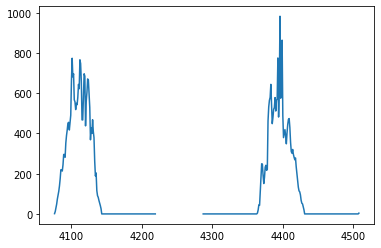

In [25]:

plt.plot(tmx_inc['Ig'].loc[isteps[0]-144:isteps[0]+288])

# Imputo datos, con la lista de la ubicaci'on  de los vac'ios de datos

/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

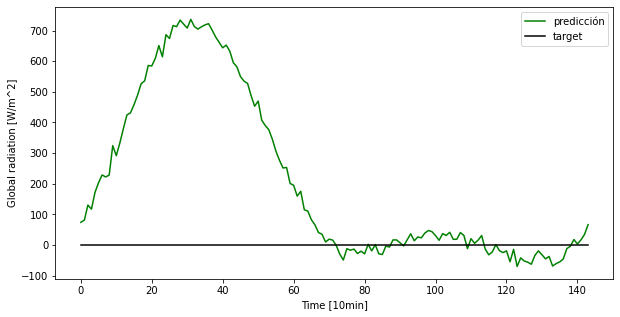

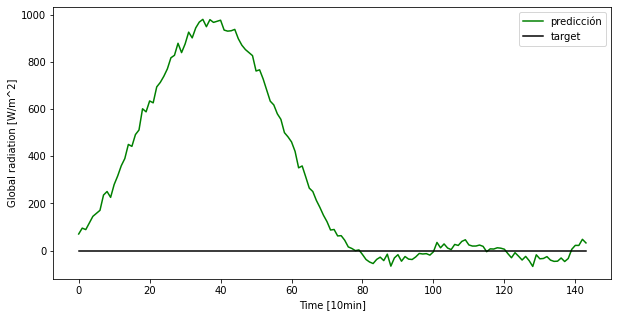

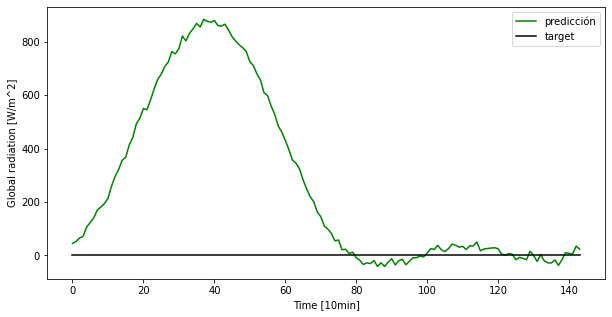

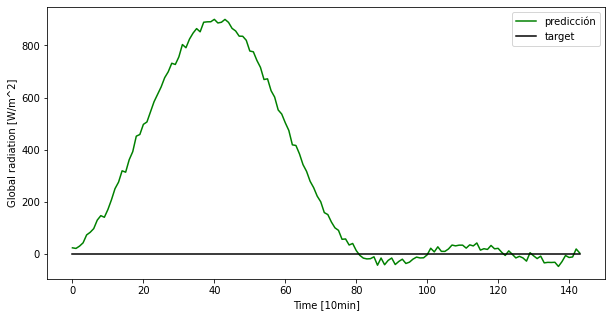

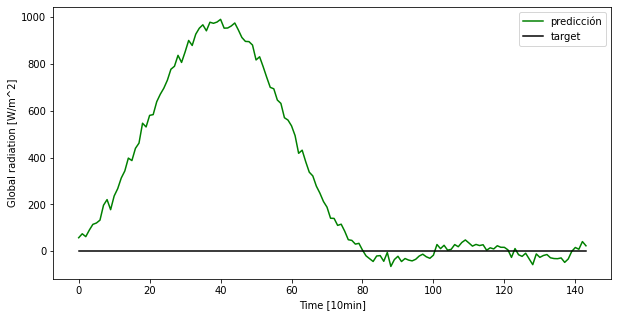

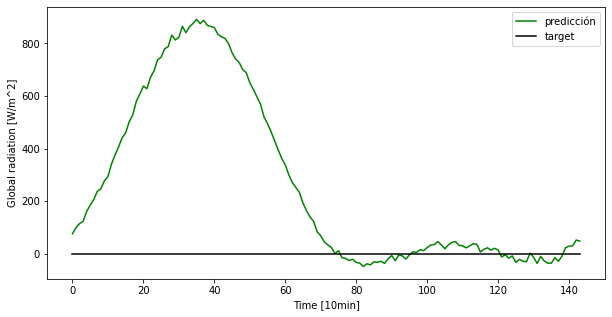

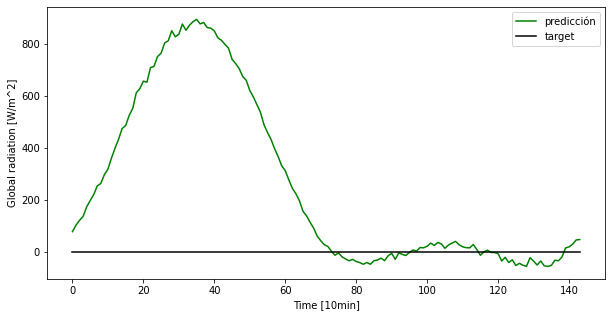

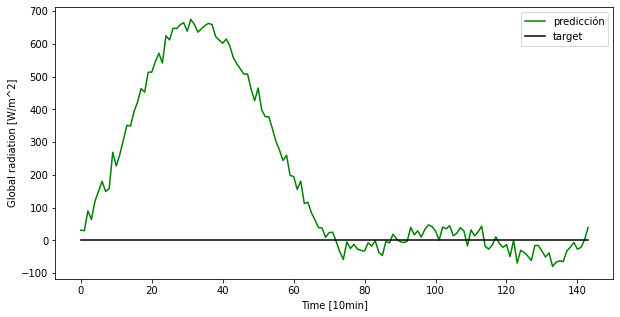

In [26]:
scaler2=load(open('y_scalerv05.pkl','rb'))
scaler=load(open('x_scalerv05.pkl','rb'))
inputs=['Ig','Ib','To','RH','azimuth','alturasolar']
output=['Ig']
in_size=144
out_size=144
heoe='../01_data/01_PreEPW/Temixco_2018_ANN_imputado'
model_name='out_s_144_lr_1e-06_in_s_144Global_azimuthaltura_BS256.h5'
path_archivo1='../01_data/02_toimpute/'
nombre_archivo1='tmxincompleto_2018_angsolares.csv'
path_archivo2='../01_data/01_PreEPW/'
nombre_archivo2='Temixco_2018_imputado_ANN.csv'
models=tst.load_model(model_name)
nombres=['time','Ib','Ig','To','RH','WS','WD','P','Eg']
for void in range(len(datavoids)): #xxx revisar el isteps -144 por qu'e lo hice?
    predi,targ=tst.Multioneshot(tmx_inc,datavoids[void],out_size,in_size,isteps[void]-144,models,inputs,output,scaler,scaler2)
    if void==0:
        imputed=tst.exporta(path_archivo1+nombre_archivo1,predi,isteps[void],datavoids[void],nombres,archivo_nombre=nombre_archivo2,save=True)
    imputed=tst.exporta(path_archivo2+nombre_archivo2,predi,isteps[void],datavoids[void],nombres,archivo_nombre=nombre_archivo2,save=True)


## Los datos de salida de red neuronal los coloco en dataframe incompleto

In [ ]:
nombres=['time','Ib','Ig','To','RH','WS','WD','P','Eg']
imputed=tst.exporta(path_archivo+nombre_archivo,predi,isteps[void],datavoids[void],nombres)

In [14]:
pd.read_csv(path_archivo+nombre_archivo)

,time,Ig,Ib,To,RH,WS,WD,P,alturasolar,azimuth
0,2018-01-01 00:00:00,0.0,0.0,18.70,36.34,1.422,316.0,87864.11,-79.806160,166.773196
1,2018-01-01 00:10:00,0.0,0.0,18.95,35.29,1.008,283.7,87876.37,-81.878940,170.053742
2,2018-01-01 00:20:00,0.0,0.0,18.94,35.43,1.565,326.0,87888.64,-83.764991,173.367191
3,2018-01-01 00:30:00,0.0,0.0,18.77,35.89,2.175,354.5,87887.21,-85.236372,176.703016
4,2018-01-01 00:40:00,0.0,0.0,18.81,36.34,1.902,348.0,87886.91,-85.827949,-179.949903
...,...,...,...,...,...,...,...,...,...,...
52555,2018-12-31 23:10:00,0.0,0.0,18.51,47.29,1.715,332.2,87484.32,-68.725457,151.345160
52556,2018-12-31 23:20:00,0.0,0.0,18.26,48.02,1.703,320.5,87470.70,-71.001501,154.338568
52557,2018-12-31 23:30:00,0.0,0.0,18.39,46.84,2.887,335.7,87455.03,-73.264218,157.400817
52558,2018-12-31 23:40:00,0.0,0.0,17.99,47.85,1.528,358.8,87470.02,-75.506650,160.527038


### Importo tambien csv con datos completos 

In [15]:
comp=pd.read_csv('../01_data/Temixco_2018_N006c.csv',index_col=0,parse_dates=True)
comp.loc['2018-11-14']

,Ib,Ig,To,RH,WS,WD,P
time,,,,,,,
2018-11-14 00:00:00,0.000,0.0,18.39,75.48,2.185,235.2,87913.87
2018-11-14 00:10:00,0.178,0.0,18.22,74.55,1.575,209.1,87909.99
2018-11-14 00:20:00,0.001,0.0,17.94,74.32,1.418,171.7,87894.02
2018-11-14 00:30:00,0.024,0.0,17.84,75.08,1.368,214.2,87883.76
2018-11-14 00:40:00,0.086,0.0,17.72,74.45,1.545,189.5,87888.01
...,...,...,...,...,...,...,...
2018-11-14 23:10:00,0.000,0.0,13.99,82.10,1.603,331.5,88030.98
2018-11-14 23:20:00,0.000,0.0,13.83,82.60,2.530,337.8,88024.17
2018-11-14 23:30:00,0.000,0.0,13.77,82.20,2.578,338.3,88000.56


In [16]:
dias=['2018-03-29',
'2018-01-30',
'2018-06-27',
'2018-06-15',
'2018-07-28',
'2018-08-12',
'2018-10-05',
'2018-11-14']

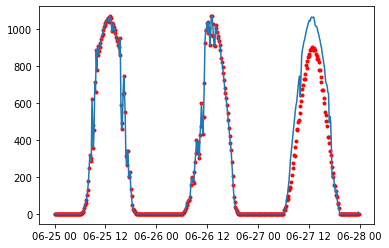

In [29]:
fecha1='2018-06-25'
fecha2=dias[2]
plt.plot(imputed.Ig.loc[fecha1:fecha2],'r.')
plt.plot(comp.Ig.loc[fecha1:fecha2])

(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2018'>], dtype=object))

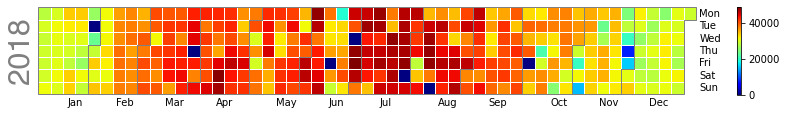

In [18]:
calplot.calplot(imputed.Ig,cmap='jet')

In [19]:
imputad0=pd.read_csv('../01_data/01_PreEPW/Temixco_2018_imputado_ANN.csv',index_col=0,parse_dates=True)
comp['me']=np.abs(comp.Ig-imputad0.Ig)

## Grafico los datos imputados contra los reales, de los dias que hac'ian falta

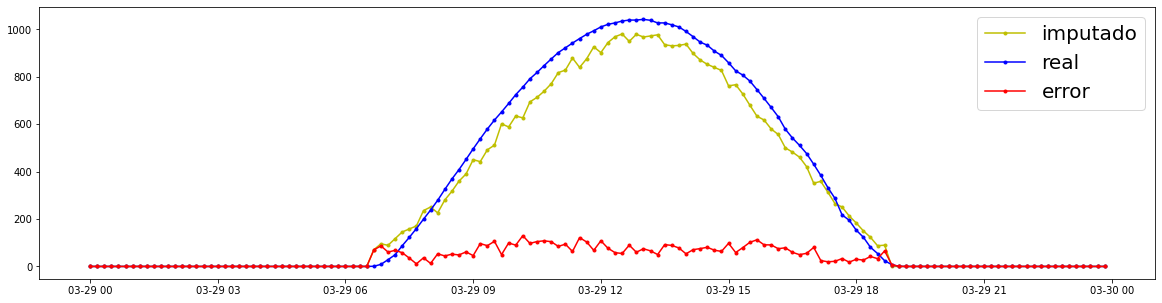

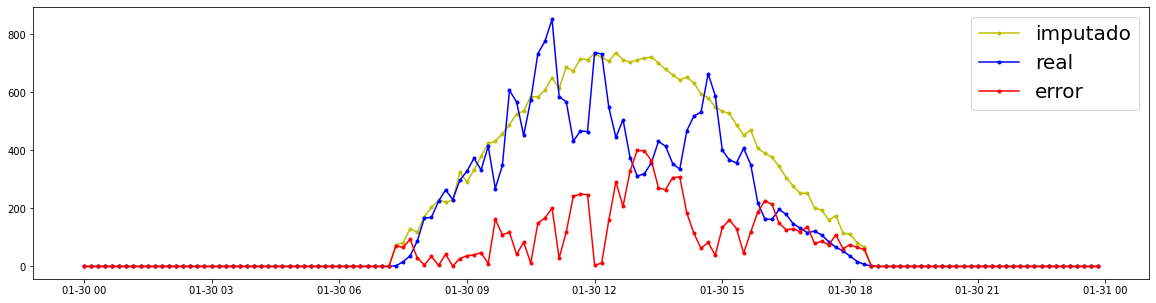

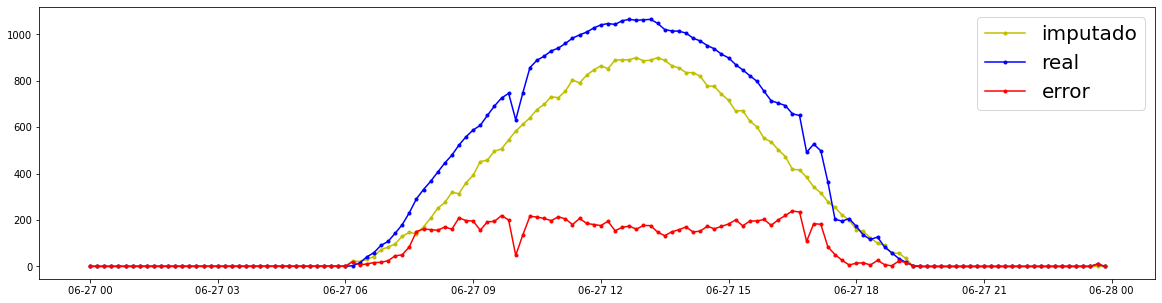

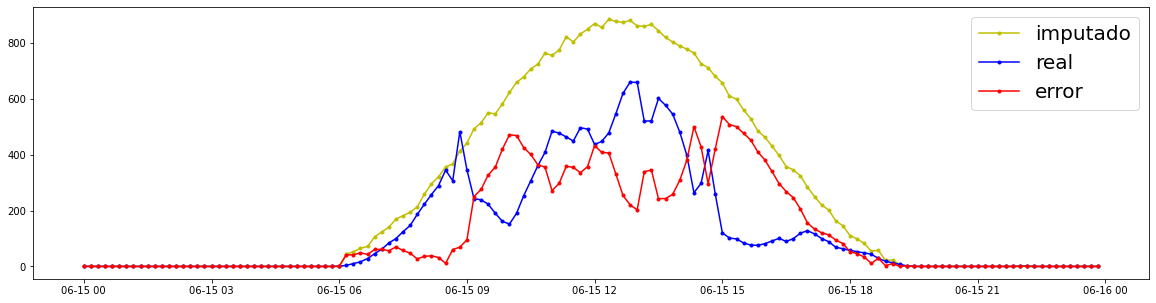

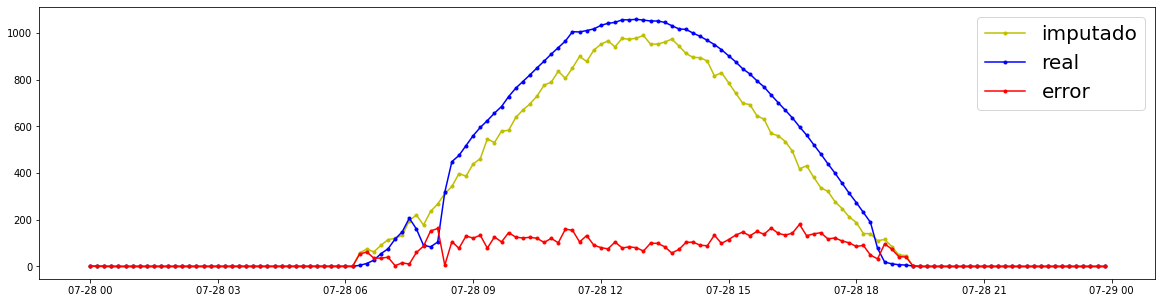

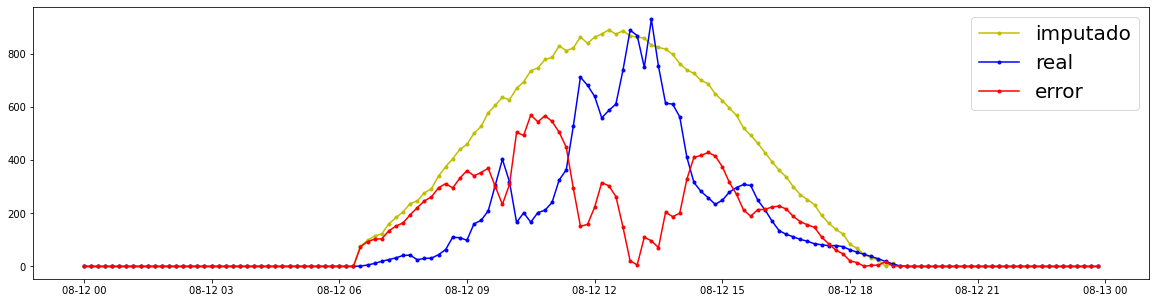

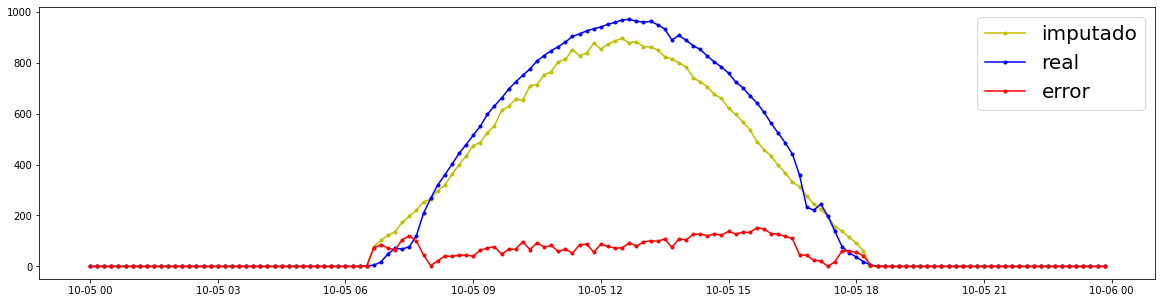

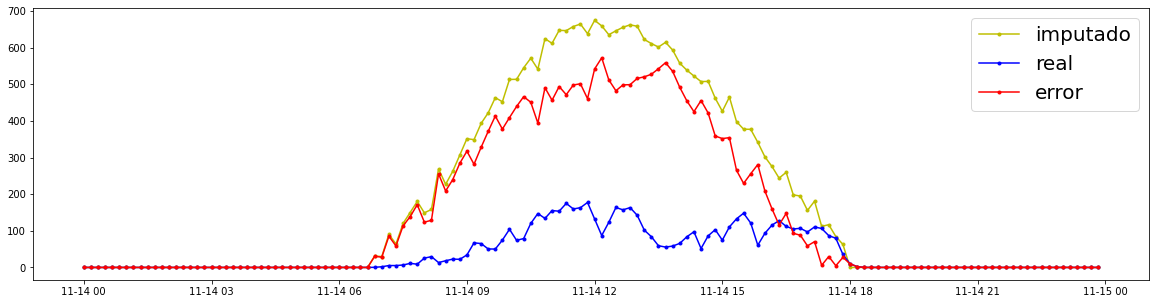

In [20]:
for dia in dias:
    fig, ax=plt.subplots(figsize=(20,5))
    plt.plot(imputad0.Ig[dia],'y.-',label='imputado')
    plt.plot(comp.Ig[dia],'b.-',label='real')
    plt.plot(comp.me[dia],'r.-',label='error')
    plt.legend(fontsize=20)
    plt.show()

(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2018'>], dtype=object))

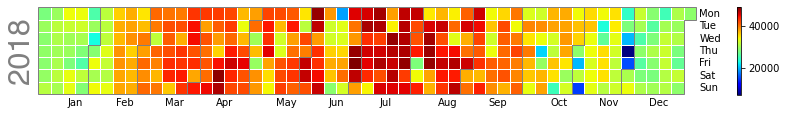

In [21]:
calplot.calplot(imputad0.Ig,cmap='jet')